Code for clustering participants in the HMTG follow-ups based on the moral phenotype model

In [1]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Compare frequencies across contexts

In [3]:
params_4 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-4_model-MP_ppSOE_precision-100.csv'),index_col=0)
params_6 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-6_model-MP_ppSOE_precision-100.csv'),index_col=0)
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),index_col=None,header=None).T)[0]
params = params_4[['sub','ClustName']].merge(params_6[['sub','ClustName']],on='sub',suffixes=['_4','_6'])
params.columns = ['sub','x4','x6']
params = params.loc[~params['sub'].isin(exclude)]
params.head()

,sub,x4,x6
0,1,MO,MO
1,2,GR,GR
2,3,MO,IA
3,4,IA,IA
4,5,IA,IA


In [4]:
clusts = np.sort(np.unique(params['x4']))
squareTable = np.zeros([len(clusts),len(clusts)])
for rowInd,rowName in enumerate(clusts):
    for colInd,colName in enumerate(clusts):
        squareTable[rowInd,colInd] = sum((params['x4']==rowName) & (params['x6']==colName))
squareTable = pd.DataFrame(squareTable,columns=clusts)
squareTable['x4'] = clusts
squareTable = squareTable.set_index('x4')
print (squareTable)

     GA    GR    IA    MO
x4                       
GA  4.0   0.0   2.0   2.0
GR  0.0  14.0   0.0   1.0
IA  3.0   0.0  22.0   6.0
MO  1.0   4.0   9.0  34.0


In [5]:
sums_x4 = np.tile(np.sum(squareTable,axis=1).values,[4,1]).T
squareTable_share = squareTable / sums_x4 * 100
squareTable_share

,GA,GR,IA,MO
x4,,,,
GA,50.000000,0.000000,25.000000,25.000000
GR,0.000000,93.333333,0.000000,6.666667
IA,9.677419,0.000000,70.967742,19.354839
MO,2.083333,8.333333,18.750000,70.833333


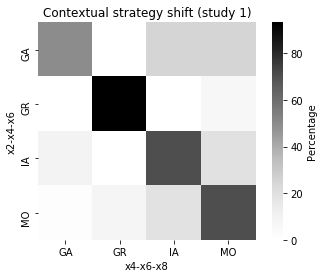

In [6]:
sns.heatmap(squareTable_share,square=True,cmap='Greys',
           cbar_kws={'label': 'Percentage'})
plt.xlabel('x4-x6-x8')
plt.ylabel('x2-x4-x6')
plt.title('Contextual strategy shift (study 1)')
plt.savefig(base_dir + '/Results/Figure4D.pdf',bbox_inches='tight')

In [7]:
# Test for difference in distributions across contexts:
import statsmodels.api as sm
sqtab = sm.stats.SquareTable(squareTable)
stats = sqtab.homogeneity(method='stuart_maxwell')
print (stats.statistic,stats.pvalue,stats.df)
# ...but gives the same result

1.7075812274368205 0.6352496325964228 3


In [8]:
# GA and MO only:
a = squareTable.loc[['GA','MO'],['GA','MO']]
print (a)
sqtab = sm.stats.SquareTable(a)
stats = sqtab.homogeneity(method='stuart_maxwell')
print (stats.statistic,stats.pvalue,stats.df)

     GA    MO
x4           
GA  4.0   2.0
MO  1.0  34.0
0.33333333333333387 0.5637028616507727 1


## Compare strategies between studies

In [9]:
params_1_4 = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
                'ParamsClusters_study-1_baseMult-4_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']].sort_values(by='ClustName')
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),index_col=None,header=None).T)[0]
params_1_4 = params_1_4.loc[~params_1_4['sub'].isin(exclude)]
params_2 = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
               'ParamsClusters_study-2_model-MP_ppSOE_precision-100.csv'),index_col=0)[
    ['sub','ClustName']].sort_values(by='ClustName')
exclude = np.array(pd.read_csv(os.path.join(base_dir,'Data/Study2/HMTG/exclude.csv'),index_col=0,header=0).T)[0]
params_2 = params_2.loc[~params_2['sub'].isin(exclude)]
params_2.head()

,sub,ClustName
34,188,GA
33,187,GA
3,155,GA
4,156,GA
45,199,GA


In [10]:
freq_1_4 = pd.DataFrame(params_1_4['ClustName'].value_counts()).reset_index()
freq_2 = pd.DataFrame(params_2['ClustName'].value_counts()).reset_index()

In [11]:
contingencyTable = freq_1_4.merge(freq_2,on='index')
contingencyTable.columns = ['Strategy','Study 1','Study 2']
contingencyTable = contingencyTable.set_index('Strategy')
contingencyTable_percentage = contingencyTable.copy()
for i in range(len(contingencyTable_percentage.columns)):
    contingencyTable_percentage.iloc[:,i] = (contingencyTable_percentage.iloc[:,i]/
                                             np.sum(contingencyTable_percentage.iloc[:,i])*100)
print (contingencyTable)
print (contingencyTable_percentage)

          Study 1  Study 2
Strategy                  
MO             48       25
IA             31       17
GR             15        2
GA              8       11
            Study 1    Study 2
Strategy                      
MO        47.058824  45.454545
IA        30.392157  30.909091
GR        14.705882   3.636364
GA         7.843137  20.000000


In [30]:
# Bar draw order
desiredOrder = ['GR','GA','IA','MO']
barStackOrder = ['MO','IA','GA','GR']

# Color map
nclust = len(desiredOrder)
cmapje = sns.color_palette('tab10',nclust)
bgMixFactor = 1
bg_cmap = [((a[0]*bgMixFactor+1)/(bgMixFactor+1),(a[1]*bgMixFactor+1)/(bgMixFactor+1),(a[2]*bgMixFactor+1)/(bgMixFactor+1)) for a in cmapje]

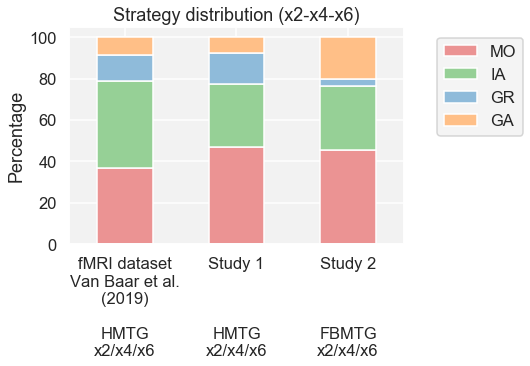

In [26]:
color_indices = [int(desiredOrder.index(contingencyTable_percentage.index[i])) for i in range(4)]
from matplotlib.colors import ListedColormap
colormap_stackedbar = ListedColormap([bg_cmap[color_indices[i]] for i in range(4)])
ax = contingencyTable_percentage.T.plot(kind='bar',stacked=True, colormap=colormap_stackedbar)
plt.legend(loc=[1.1,.5])
ax.set_xticklabels(contingencyTable_percentage.columns,rotation=0)
plt.title('Strategy distribution (x2-x4-x6)')
plt.ylabel('Percentage');

In [13]:
obs = np.array(contingencyTable.T)
print (obs)
out = scipy.stats.chi2_contingency(obs)
print ('Chi-square = %.2f, df = %i, p = %.4f'%(out[0],out[2],out[1]))

[[48 31 15  8]
 [25 17  2 11]]
Chi-square = 8.43, df = 3, p = 0.0379


In [14]:
obs = np.array(contingencyTable.loc[['GA','IA'],:].T)
print (obs)
out = scipy.stats.chi2_contingency(obs)
print ('Chi-square = %.2f, df = %i, p = %.4f'%(out[0],out[2],out[1]))

[[ 8 31]
 [11 17]]
Chi-square = 1.98, df = 1, p = 0.1595


In [15]:
obs = np.array(contingencyTable.loc[['GA','MO'],:].T)
print (obs)
out = scipy.stats.chi2_contingency(obs)
print ('Chi-square = %.2f, df = %i, p = %.4f'%(out[0],out[2],out[1]))

[[ 8 48]
 [11 25]]
Chi-square = 2.62, df = 1, p = 0.1058


In [16]:
obs = np.array(contingencyTable.loc[['GA','GR'],:].T)
print (obs)
out = scipy.stats.chi2_contingency(obs)
print ('Chi-square = %.2f, df = %i, p = %.4f'%(out[0],out[2],out[1]))

[[ 8 15]
 [11  2]]
Chi-square = 6.40, df = 1, p = 0.0114


In [17]:
# Which pairwise difference is driving the omnibus effect?
import itertools
groups = ['GA','IA','MO','GR']
combinations = []
for element in itertools.product(groups,groups):
    if (element[0] != element[1]) & (list(np.sort(element)) not in combinations):
        combinations = combinations + [list(np.sort(element))]
# print combinations
for comb in combinations:
    obs = np.array(contingencyTable.loc[comb,:].T)
    print (comb)
    out = scipy.stats.chi2_contingency(obs)
    print ('Chi-square = %.2f, df = %i, p = %.4f, p_corr = %.4f'%(out[0],out[2],out[1], out[1]*6))

['GA', 'IA']
Chi-square = 1.98, df = 1, p = 0.1595, p_corr = 0.9571
['GA', 'MO']
Chi-square = 2.62, df = 1, p = 0.1058, p_corr = 0.6345
['GA', 'GR']
Chi-square = 6.40, df = 1, p = 0.0114, p_corr = 0.0686
['IA', 'MO']
Chi-square = 0.00, df = 1, p = 0.9498, p_corr = 5.6990
['GR', 'IA']
Chi-square = 2.35, df = 1, p = 0.1255, p_corr = 0.7528
['GR', 'MO']
Chi-square = 2.33, df = 1, p = 0.1265, p_corr = 0.7592


##### Compare with fMRI dataset

In [18]:
obs = np.array([[21,24,7,5],[25,17,2,11]])
print (obs)
out = scipy.stats.chi2_contingency(obs)
print ('Chi-square = %.2f, df = %i, p = %.4f'%(out[0],out[2],out[1]))

[[21 24  7  5]
 [25 17  2 11]]
Chi-square = 6.54, df = 3, p = 0.0882


In [19]:
import itertools
groups = np.arange(4)
combinations = []
for element in itertools.product(groups,groups):
    if (element[0] != element[1]) & (list(np.sort(element)) not in combinations):
        combinations = combinations + [list(np.sort(element))]
print (combinations)
for comb in combinations:
    print (comb)
    out = scipy.stats.chi2_contingency(obs[:,comb])
    print ('Chi-square = %.2f, df = %i, p = %.4f, p_corr = %.4f'%(out[0],out[2],out[1], out[1]*6))

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
[0, 1]
Chi-square = 0.97, df = 1, p = 0.3243, p_corr = 1.9460
[0, 2]
Chi-square = 1.96, df = 1, p = 0.1620, p_corr = 0.9717
[0, 3]
Chi-square = 0.51, df = 1, p = 0.4768, p_corr = 2.8606
[1, 2]
Chi-square = 0.49, df = 1, p = 0.4854, p_corr = 2.9122
[1, 3]
Chi-square = 2.42, df = 1, p = 0.1195, p_corr = 0.7171
[2, 3]
Chi-square = 3.31, df = 1, p = 0.0690, p_corr = 0.4143


##### Plot including previous results

In [20]:
contingencyTable_percentage = contingencyTable.copy()
for i in range(len(contingencyTable_percentage.columns)):
    contingencyTable_percentage.iloc[:,i] = (contingencyTable_percentage.iloc[:,i]/
                                             np.sum(contingencyTable_percentage.iloc[:,i])*100)
contingencyTable_percentage['fMRI dataset'] = np.array([21, 24, 7,5])/sum([21,24,7,5])*100
contingencyTable_percentage = contingencyTable_percentage[['fMRI dataset','Study 1', 'Study 2']]
contingencyTable_percentage.columns = ['fMRI dataset\nVan Baar et al.\n(2019)\n\nHMTG\nx2/x4/x6',
                                       'Study 1\n\n\n\nHMTG\nx2/x4/x6', 
                                       'Study 2\n\n\n\nFBMTG\nx2/x4/x6']

In [21]:
contingencyTable_percentage

,fMRI dataset\nVan Baar et al.\n(2019)\n\nHMTG\nx2/x4/x6,Study 1\n\n\n\nHMTG\nx2/x4/x6,Study 2\n\n\n\nFBMTG\nx2/x4/x6
Strategy,,,
MO,36.842105,47.058824,45.454545
IA,42.105263,30.392157,30.909091
GR,12.280702,14.705882,3.636364
GA,8.771930,7.843137,20.000000


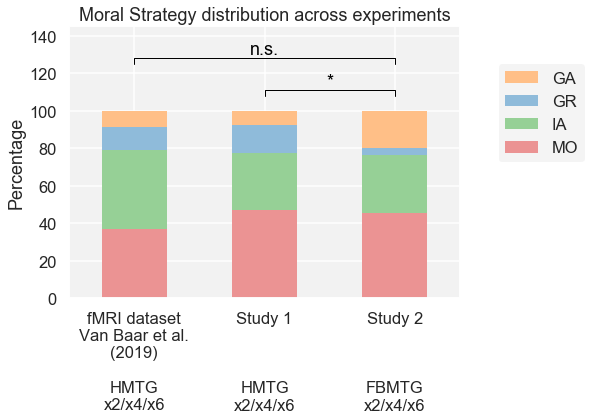

In [29]:
sns.set_style('darkgrid', {"axes.facecolor": ".95"})
sns.set_context('talk')
color_indices = [int(desiredOrder.index(contingencyTable_percentage.index[i])) for i in range(4)]
from matplotlib.colors import ListedColormap
colormap_stackedbar = ListedColormap([bg_cmap[color_indices[i]] for i in range(4)])
ax = contingencyTable_percentage.T.plot(kind='bar',stacked=True, colormap=colormap_stackedbar,
                                       lw=0,figsize=[7,5])
handles, labels = ax.get_legend_handles_labels()
leg = plt.legend(handles[::-1], labels[::-1], loc=[1.1,.5])
leg.get_frame().set_linewidth(0.0)
ax.set_xticklabels(contingencyTable_percentage.columns,rotation=0)
plt.title('Moral Strategy distribution across experiments')
plt.ylabel('Percentage');
plt.ylim([0,145])
FigureTools.add_sig_markers(ax,relationships=[[1,2,0.03]],distScale=.4, ystart=108)
FigureTools.add_sig_markers(ax,relationships=[[0,2,.1]],distScale=.4, ystart=125)
plt.savefig(base_dir + '/Results/Figure5.pdf',bbox_inches='tight')